In [1]:
import matplotlib.pyplot as plt
from time import time
import csv
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys

In [2]:
folder = 'results_16_08'

In [3]:
df = pd.read_csv(f'{folder}/raw_copy.csv')

# df['Name'] = df['Distorted'].apply(lambda x : (m := x.split('/')[3], m.replace('_x265', ''))[-1])
df['Reference'] = df['Reference'].apply(lambda x : str(x).split('/')[-1])
df['Distorted'] = df['Distorted'].apply(lambda x : str(x).split('/')[-1].split('.')[0])

df.to_csv(f'{folder}/pp.csv', index=False)

In [4]:
df = pd.read_csv(f'{folder}/pp.csv')
subj = pd.read_csv('subjective_scores_2019.csv')

result = pd.merge(df, subj, left_on = 'Distorted', right_on = 'Video_name')
result.to_csv(f'{folder}/merged.csv', index=False)

In [5]:
data = pd.read_csv(f'{folder}/merged.csv')

MODE = ['pearson', 'spearman']
data = pd.read_csv(f'{folder}/merged.csv')
metrics = ['ssim']
presets = sorted(set(data['Preset']))

def calc_corr(x, mode):
    return np.array(x.corr(mode))[0, 1]

tables_str = {metric: dict() for metric in metrics}
tables_val = {metric: {False: [], True: []} for metric in metrics}

corr = data.copy()
corr = corr.groupby(['Metric', 'Mask', 'Sequence', 'Preset'], group_keys=True)\
    .apply(lambda x : pd.Series(
        [calc_corr(x[['Metric_val', 'Subjective']], MODE[0]), calc_corr(x[['Metric_val', 'Subjective']], MODE[1]), len(x)], 
        index=[MODE[0], MODE[1], 'Sample_size']
))

def print_f(f):
    return '%.5f' % (f,)

def DescrStatsW(col, weights):
    total = weights.sum()
    col *= weights / total * len(col)
    return col

def weigh_func(col, weights, mode='mean'):
    st = DescrStatsW(col, weights=weights)
    return st.mean()

def average_rho(corrs: pd.Series, weights: pd.Series):
    corrs = pd.DataFrame(corrs)
    d = corrs.apply(lambda x: np.arctanh(x)).replace([np.inf, -np.inf], [np.arctanh(0.99), np.arctanh(-0.99)]) \
               .apply(lambda x: weigh_func(x, weights, 'mean')) \
               .apply(lambda x: np.tanh(x)).abs().replace([0.99], [1])
    return float(d)

corr_by_video = corr.groupby(['Metric', 'Sequence', 'Mask']).apply(lambda row : \
    pd.Series([
        print_f(average_rho(row[MODE[0]], row['Sample_size'])), 
        print_f(average_rho(row[MODE[1]], row['Sample_size']))], 
    index=[MODE[0].capitalize(), MODE[1].capitalize()]))
corr_by_metric = corr.groupby(['Metric', 'Mask']).apply(lambda row : \
    pd.Series([
        print_f(average_rho(row[MODE[0]], row['Sample_size'])), 
        print_f(average_rho(row[MODE[1]], row['Sample_size']))], 
    index=[MODE[0].capitalize(), MODE[1].capitalize()]))

print(corr_by_video)
print(corr_by_metric)

corr_by_video.to_excel(f'{folder}/corr_by_video.xlsx')
corr_by_metric.to_excel(f'{folder}/corr_by_metric.xlsx')

corr_by_video.reset_index().to_csv(f'{folder}/corr_by_video.csv', index=False)
corr_by_metric.reset_index().to_csv(f'{folder}/corr_by_metric.csv', index=False)


                            Pearson Spearman
Metric Sequence      Mask                   
ssim   tractor_short False  0.94034  0.90977
                     True   0.94186  0.90376
              Pearson Spearman
Metric Mask                   
ssim   False  0.94034  0.90977
       True   0.94186  0.90376


In [6]:
data.copy().groupby(['Metric', 'Mask', 'Sequence', 'Preset'], group_keys=True)\
    .apply(lambda x : pd.Series(
        [calc_corr(x[['Metric_val', 'Subjective']], MODE[0]), calc_corr(x[['Metric_val', 'Subjective']], MODE[1]), len(x)], 
        index=[MODE[0], MODE[1], 'Sample_size']
))

pearson  spearman  Sample_size
Metric Mask  Sequence      Preset                                        
ssim   False tractor_short mv_subjective  0.940339  0.909774         20.0
       True  tractor_short mv_subjective  0.941857  0.903759         20.0

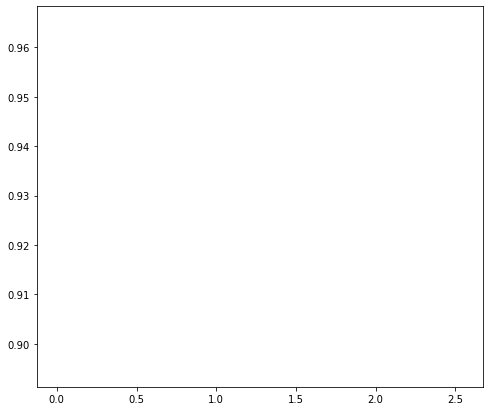

In [7]:
corr = 'Pearson'
data = pd.read_csv(f'{folder}/merged.csv')
by_seq = pd.read_csv(f'{folder}/corr_by_video.csv')
by_metr = pd.read_csv(f'{folder}/corr_by_metric.csv')

names = sorted(set(data['Sequence']))

for metric in ['ssim']:
    fig, ax = plt.subplots(figsize=(8, 7))

    for mask in [False, True]:
        for name in names:
            df = data[(data['Sequence'] == name) & (data['Mask'] == mask) & (data['Metric'] == metric)]

            met = np.array(df['Metric_val'])
            subj = np.array(df['Subjective'])
            r = float(by_seq[(by_seq['Sequence'] == name) & (by_seq['Mask'] == mask) & (by_seq['Metric'] == metric)][corr])

            ax.scatter(subj, met, label=f'%s, %-6s PCC=%.3f' % (name, str(mask) + ',', r))
        ro_total = float(by_metr[(by_metr['Mask'] == mask) & (by_metr['Metric'] == metric)][corr])
        ax.set_title(f'metric={metric}, mask={mask}, PCC=%.3f' % (ro_total))
        ax.set_xlabel('Subjective')
        ax.set_ylabel('Metric')
        ax.legend(loc='lower right')
        fig.show()

        fig.savefig(f'{folder}/metric={metric}_mask={mask}.jpg')

        xlims, ylims = ax.get_xlim(), ax.get_ylim()
        ax.clear()
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
